In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import re
from collections import Counter
from datetime import datetime
from pprint import pprint
import math

In [2]:
filePath = "..\\..\\Files\\"

In [3]:
reloadDataFiles = False

# Import files

In [4]:
def LoadDrFile(initials):
    drDfVisists = pd.read_excel(f"{filePath}{initials}_besök.xlsx");
    drDfPhone = pd.read_excel(f"{filePath}{initials}_telefon.xlsx");
    drDfAdmin = pd.read_excel(f"{filePath}{initials}_indirekt.xlsx");
    drDf = drDfVisists.append(drDfPhone, ignore_index=True)
    drDf = drDf.append(drDfAdmin, ignore_index=True)
    limitColsDf = drDf.loc[:, ["Personnr", "Variabelnamn i M4", "Besöksdatum"] ]
    nonNaNDf = limitColsDf.loc[limitColsDf['Personnr'].notnull()]
    nonNaNDf["Initials"] = initials
    return nonNaNDf

In [5]:
if reloadDataFiles:
    JK = LoadDrFile("JK")
    MT = LoadDrFile("MT")
    LW = LoadDrFile("LW")
    MN = LoadDrFile("MN")
    MS = LoadDrFile("MS")
    RA = LoadDrFile("RA")
    QR = LoadDrFile("QR")

In [6]:
if reloadDataFiles:
    print(RA.head(1))

In [7]:
if reloadDataFiles:
    listingOriginalDf = pd.read_csv(f"{filePath}Listing_2022-05-03.csv", sep=";")
    listingDf = listingOriginalDf.loc[:, ["Pnr", "Vårdgivare"]]
    listingDf.head(2)

In [8]:
DrToInitials = {
    'ARVIDSSON, RASMUS': "RA",
    'HÄLSOCENTRALEN SANKT HANS, VC': "HC",
    'KOSJERINA, JULIJANA': "JK",
    'NILSSON, MARIA K (ST-LÄKARE)': "MN",
    'ROMERO, QUINCI (ST-LÄKARE)': "QR",
    'SVENSSON, MARIA MC': "MS",
    'TRATTNER, MICHAEL': "MT",
    'WIDÉN, LINN': "LW",
}

In [9]:
if reloadDataFiles:
    listingDf.rename(columns={"Pnr": "Personnr", "Vårdgivare": "Listing"}, inplace=True)
    listingDf["Listing"] = listingDf["Listing"].apply(lambda name: DrToInitials[name] )
    listingDf.head()

In [10]:
if reloadDataFiles:
    listingDict = dict(zip(listingDf["Personnr"], listingDf["Listing"]))

## Lägg ihop alla besök med listad läkar som egen kolumn

In [11]:
if reloadDataFiles:
    allContacts = JK.append(MT, ignore_index=True)
    allContacts = allContacts.append(LW, ignore_index=True)
    allContacts = allContacts.append(MN, ignore_index=True)
    allContacts = allContacts.append(MS, ignore_index=True)
    allContacts = allContacts.append(RA, ignore_index=True)
    allContacts = allContacts.append(QR, ignore_index=True)

In [12]:
if reloadDataFiles:
    allContacts["Personnr"] = allContacts["Personnr"].str.replace(r"(\d{8})(\w{4})", r"\1-\2")

In [13]:
if reloadDataFiles:
    print(set(allContacts["Variabelnamn i M4"]))

In [14]:
visitTypeDict = {
    'Indirekt kontakt': "adm",
    'Planerade mottagningsbesök': "visit",
    'Planerat hembesök': "visit",
    'Telefon': "tel"
}

In [15]:
if reloadDataFiles:
    allContacts.rename(columns = {"Variabelnamn i M4" : "VisitType"}, inplace=True)
    allContacts["VisitType"] = allContacts["VisitType"].apply(lambda x: visitTypeDict[x])
    print(allContacts.head(1))

In [16]:
def checkListing(personnr):
    if not personnr in listingDict:
        return "unknown"
    
    return listingDict[personnr]

In [17]:
if reloadDataFiles:
    allContacts["Listing"] = allContacts["Personnr"].apply( checkListing )

In [18]:
if reloadDataFiles:
    allContacts.to_excel(f"{filePath}allContacts.xlsx")
else:
    allContacts = pd.read_excel(f"{filePath}allContacts.xlsx")
    allContacts.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], inplace=True)

In [19]:
if reloadDataFiles:
    listingDf["Visits (n)"] = listingDf["Personnr"].apply(
        lambda personnr: len(allContacts.loc[ 
            (allContacts["Personnr"] == personnr) & 
            (allContacts["VisitType"] == "visit")].index))

    listingDf["Tel (n)"] = listingDf["Personnr"].apply(
        lambda personnr: len(allContacts.loc[ 
            (allContacts["Personnr"] == personnr) & 
            (allContacts["VisitType"] == "tel")].index))

    listingDf["Adm (n)"] = listingDf["Personnr"].apply(
        lambda personnr: len(allContacts.loc[ 
            (allContacts["Personnr"] == personnr) & 
            (allContacts["VisitType"] == "adm")].index))
    
    listingDf.to_excel(f"{filePath}listingDf.xlsx")
else:
    listingDf = pd.read_excel(f"{filePath}listingDf.xlsx")
    listingDf.drop(columns=["Unnamed: 0"], inplace=True)

### Lägg till antalet besök per listad pat i listingDf

In [20]:
listingDf.loc[:, ["Listing", "Visits (n)", "Tel (n)", "Adm (n)"]].head(2)

,Listing,Visits (n),Tel (n),Adm (n)
0,HC,2,0,6
1,HC,3,1,2


In [21]:
unlistedDf = listingDf.loc[ listingDf["Listing"] == "HC" ]
print(len(unlistedDf.index))


3339


In [22]:
#allContacts.loc[ allContacts["Personnr"] == "some_nr" ]

## Filtrera bort patienter som redan är listade

In [23]:
unlistedContacts = allContacts.loc[ allContacts["Listing"] == "HC" ]

In [24]:
unlistedContacts.to_excel(f"{filePath}unlistedContacts.xlsx")

In [25]:
len(set(unlistedContacts.loc[:,"Personnr"]))

962

## Ta fram inaktiva patienter (listad på HC som ej haft besök sista åren)

In [26]:
hasVisitSet = set( allContacts.loc[ allContacts["VisitType"] == "visit" ].loc[ : , "Personnr"] )

In [27]:
print(f"There were {len(allContacts.index)} contacts in total.")
print(f"There were {len(allContacts.loc[ (allContacts['Listing'] == 'HC') ].index)} contacts from unlisted patients.")
unlistedHasContactSet = set( allContacts.loc[ (allContacts["Listing"] == "HC") ].loc[ : , "Personnr"] )
print(f"{len(unlistedHasContactSet)} unlisted patients had som form of contact.")
unlistedHasVisitSet = set( allContacts.loc[ (allContacts["Listing"] == "HC") & (allContacts["VisitType"] == "visit") ].loc[ : , "Personnr"] )
print(f"{len(unlistedHasVisitSet)} unlisted patients had a physical visit.")
unlistedHasTelSet = set( allContacts.loc[ (allContacts["Listing"] == "HC") & (allContacts["VisitType"] == "tel") ].loc[ : , "Personnr"] )
print(f"{len(unlistedHasTelSet)} unlisted patients had a tel appointment.")

There were 29151 contacts in total.
There were 2170 contacts from unlisted patients.
962 unlisted patients had som form of contact.
673 unlisted patients had a physical visit.
259 unlisted patients had a tel appointment.


In [28]:
print(f"There are {len(listingDf.loc[ listingDf['Listing'] == 'HC' ].index)} unlisted patients in total")

There are 3339 unlisted patients in total


In [29]:
unlistedNoContactSet = listingDf.loc[ (listingDf["Listing"] == "HC") & ~(listingDf["Personnr"].isin(unlistedHasContactSet)) ]
#print(unlistedNoContactSet[:5])
print(len(unlistedNoContactSet))

2377


In [30]:
unlistedNoContactDf = unlistedDf.loc[ ~(unlistedDf["Personnr"].isin(unlistedHasContactSet)) ]
unlistedNoContactDf = unlistedNoContactDf.copy()
print(len(unlistedNoContactDf.index))
unlistedNoContactDf.loc[: , ["Listing", "Visits (n)", "Tel (n)", "Adm (n)"]].tail(3)

2377


,Listing,Visits (n),Tel (n),Adm (n)
3336,HC,0,0,0
3337,HC,0,0,0
3338,HC,0,0,0


# Beräkningar

#### Använd:
* unlistedContacts - DF med alla olistade patienter som haft besök
* unlistedNoContactDf - DF med patienter som är olistade och inte har haft några kontakter
* unlistedContactsDf - DF med alla kontakter med olistade patienter
* unlistedHasContactSet - set med alla olistade patienter som har en kontakt

### Patient to visits per doctor df

In [31]:
initialsList = ["MT", "JK", "LW", "QR", "MS", "MN", "RA"]
visitTypes = ["visit", "tel", "adm"]

In [32]:
countAndScoreColNames = []
for initials in initialsList:
    for visitType in visitTypes:
        countAndScoreColNames.append(f"{initials}_{visitType}")
        countAndScoreColNames.append(f"{initials}_{visitType}_score")
    countAndScoreColNames.append(f"{initials}_score")
countAndScoreColNames.append(f"total_score")
countAndScoreColNames

['MT_visit',
 'MT_visit_score',
 'MT_tel',
 'MT_tel_score',
 'MT_adm',
 'MT_adm_score',
 'MT_score',
 'JK_visit',
 'JK_visit_score',
 'JK_tel',
 'JK_tel_score',
 'JK_adm',
 'JK_adm_score',
 'JK_score',
 'LW_visit',
 'LW_visit_score',
 'LW_tel',
 'LW_tel_score',
 'LW_adm',
 'LW_adm_score',
 'LW_score',
 'QR_visit',
 'QR_visit_score',
 'QR_tel',
 'QR_tel_score',
 'QR_adm',
 'QR_adm_score',
 'QR_score',
 'MS_visit',
 'MS_visit_score',
 'MS_tel',
 'MS_tel_score',
 'MS_adm',
 'MS_adm_score',
 'MS_score',
 'MN_visit',
 'MN_visit_score',
 'MN_tel',
 'MN_tel_score',
 'MN_adm',
 'MN_adm_score',
 'MN_score',
 'RA_visit',
 'RA_visit_score',
 'RA_tel',
 'RA_tel_score',
 'RA_adm',
 'RA_adm_score',
 'RA_score',
 'total_score']

In [33]:
def countPatientsContactsWithDr(personnr, initials, visitType):
    return len(unlistedContacts.loc[ (unlistedContacts["Personnr"] == personnr) & 
                                   (unlistedContacts["Initials"] == initials) &
                                   (unlistedContacts["VisitType"] == visitType)].index)

#### Vikta besöken efter hur längesen de skedde.

In [34]:
# Weight factor where a visit which happened just now is worth 2 points
# one which happened 1 year ago 1.5 points
# and a bit less than 2 years ago 1 point.

def weightFactorFromDate(dateString):
    date = datetime.strptime(dateString, '%Y-%m-%d')
    originDate = datetime.strptime("2022-04-30", '%Y-%m-%d')
    dateDiff = (originDate - date).days
    return 2 - (dateDiff/650)
    
print(weightFactorFromDate("2022-04-30"))
print(weightFactorFromDate("2021-10-30"))
print(weightFactorFromDate("2021-04-30"))
print(weightFactorFromDate("2020-10-30"))
print(weightFactorFromDate("2020-07-30"))
print(weightFactorFromDate("2020-07-7"))

visitTypeWeightDict = {
    "visit": 1,
    "tel": 0.35,
    "adm": 0.2,
}

2.0
1.72
1.4384615384615385
1.1584615384615384
1.016923076923077
0.9815384615384615


In [35]:
def calculateRowScore(row):
    dateWeightFactor = weightFactorFromDate(row["Besöksdatum"])
    return visitTypeWeightDict[ row["VisitType"] ] * dateWeightFactor

testRow = unlistedContacts.loc[ list(unlistedContacts.index)[1200] , :]
pprint(testRow.loc[list(set(testRow.index) - set(["Personnr"]))])
print(f"Score: {calculateRowScore( testRow )}")

VisitType           visit
Initials               MS
Listing                HC
Besöksdatum    2022-03-28
Name: 21798, dtype: object
Score: 1.9492307692307693


In [36]:
unlistedContacts["rowScore"] = unlistedContacts.apply(calculateRowScore, axis=1)

C:\ProgramData\Anaconda3\envs\aienv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [37]:
unlistedContacts.loc[:, ["VisitType", "Besöksdatum", "Initials", "Listing", "rowScore"]].head(2)

,VisitType,Besöksdatum,Initials,Listing,rowScore
0,visit,2021-02-01,JK,HC,1.303077
1,visit,2021-03-01,JK,HC,1.346154


In [38]:
unlistedContacts.columns

Index(['Personnr', 'VisitType', 'Besöksdatum', 'Initials', 'Listing',
       'rowScore'],
      dtype='object')

In [39]:
def createPatientRowOfVisitsPerDr(personnr):
    patientsIndividualDf = unlistedContacts.loc[ unlistedContacts["Personnr"] == personnr ]
    
    row = {"Personnr": personnr}
    totalScore = 0
    
    for initials in initialsList:
        
        drIndividualDf = patientsIndividualDf.loc[ patientsIndividualDf["Initials"] == initials ]
        
        individualScore = 0
        
        for visitType in visitTypes:
            
            visitTypeDf = drIndividualDf.loc[ drIndividualDf["VisitType"] == visitType ]
            row[f"{initials}_{visitType}"] = len( visitTypeDf.index )
            score = visitTypeDf["rowScore"].sum()
            row[f"{initials}_{visitType}_score"] = score
            individualScore += score
            
        row[f"{initials}_score"] = individualScore
        totalScore += individualScore
    row[f"total_score"] = totalScore
    return row

In [40]:
patientVisitPerDrList = []
limit = -1
i = 0
for personnr in unlistedHasContactSet:
    i += 1
    if limit > 0 and i > limit:
        break
    
    patientVisitPerDrList.append(createPatientRowOfVisitsPerDr(personnr))
    
    
unlistedPatientScoreDf = pd.DataFrame(patientVisitPerDrList, columns=["Personnr"] + countAndScoreColNames)
unlistedPatientScoreDf.loc[:, countAndScoreColNames].head()

,MT_visit,MT_visit_score,MT_tel,MT_tel_score,MT_adm,MT_adm_score,MT_score,JK_visit,JK_visit_score,JK_tel,...,MN_adm_score,MN_score,RA_visit,RA_visit_score,RA_tel,RA_tel_score,RA_adm,RA_adm_score,RA_score,total_score
0,0,0.000000,0,0.0,0,0.0,0.000000,0,0.0,0,...,0.0,0.000000,0,0.0,0,0.0,0,0.0,0.0,6.831385
1,2,2.024615,0,0.0,0,0.0,2.024615,0,0.0,0,...,0.0,0.000000,0,0.0,0,0.0,0,0.0,0.0,2.024615
2,0,0.000000,0,0.0,0,0.0,0.000000,0,0.0,0,...,0.0,1.715385,0,0.0,0,0.0,0,0.0,0.0,1.715385
3,0,0.000000,0,0.0,0,0.0,0.000000,0,0.0,0,...,0.0,0.000000,0,0.0,0,0.0,0,0.0,0.0,4.217769
4,0,0.000000,0,0.0,0,0.0,0.000000,0,0.0,0,...,0.0,0.000000,0,0.0,0,0.0,0,0.0,0.0,0.424308


In [41]:
def countDrAmountOfPatientsForEachVisitAmount(initials):
    counter = Counter(unlistedPatientScoreDf[f"{initials}_visit"])
    return dict(counter)
    #return sorted(counter.items())

In [42]:
unlistedVisistsPerDrDict = {}
for initials in initialsList:
    unlistedVisistsPerDrDict[initials] = countDrAmountOfPatientsForEachVisitAmount(initials)
    
unlistedVisistsPerDrDict

{'MT': {0: 869, 2: 14, 1: 76, 3: 2, 4: 1},
 'JK': {0: 864, 1: 86, 2: 12},
 'LW': {1: 129, 0: 814, 2: 16, 3: 2, 5: 1},
 'QR': {3: 5, 0: 797, 2: 28, 1: 131, 4: 1},
 'MS': {0: 837, 1: 112, 2: 13},
 'MN': {0: 893, 1: 62, 2: 7},
 'RA': {0: 848, 1: 98, 2: 15, 3: 1}}

In [43]:
unlistedVisistsPerDrList = []
for i in range(6):
    #row = {"Visits (n)": i}
    row = {}
    for initials in initialsList:
        if i in unlistedVisistsPerDrDict[initials]:
            row[initials] = unlistedVisistsPerDrDict[initials][i]
        else:
            row[initials] = 0
    unlistedVisistsPerDrList.append(row)
    
unlistedVisistsPerDrDf = pd.DataFrame(unlistedVisistsPerDrList, columns=initialsList)
unlistedVisistsPerDrDf

,MT,JK,LW,QR,MS,MN,RA
0,869,864,814,797,837,893,848
1,76,86,129,131,112,62,98
2,14,12,16,28,13,7,15
3,2,0,2,5,0,0,1
4,1,0,0,1,0,0,0
5,0,0,1,0,0,0,0


### Extremt aktiva till JK och MT

Histogram of total score


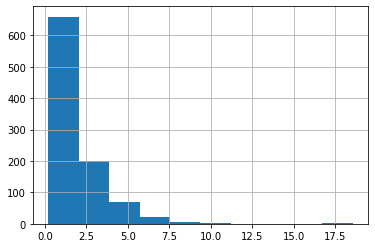

In [44]:
print("Histogram of total score")
unlistedPatientScoreDf.loc[:, "total_score"].hist()

### Most active patients

In [108]:
def ageFromPersonnr(personnrStr):
    match = re.search(r"(\d{4})", personnrStr)
    year = int(match[1])
    return 2022 - year
    
ageFromPersonnr("19870323-abcd")

35

In [46]:
ageAndScoreDf = unlistedPatientScoreDf.loc[:, ["Personnr", "total_score"]].copy()

In [47]:
ageAndScoreDf["age"] = ageAndScoreDf["Personnr"].apply(ageFromPersonnr)

## Age distribution of patients

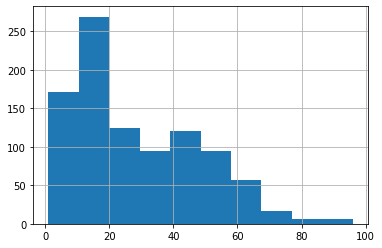

In [48]:
ageAndScoreDf["age"].hist()

### Contact score per age

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


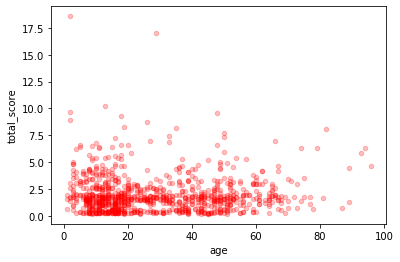

In [49]:
test = np.array([1,0,0,0.25])
test.reshape(1, -1)
ageAndScoreDf.plot.scatter(x="age", y="total_score", c=test )

In [50]:
scoreLimitForHeavy = 5
unlistedHeavySet = set( unlistedPatientScoreDf.loc[ unlistedPatientScoreDf["total_score"] >= scoreLimitForHeavy ].loc[ : ,"Personnr"] )
heavyN = len(unlistedHeavySet)
unlistedN = len(unlistedDf.index)
print(f"Heavy ({heavyN}) / unlisted {unlistedN} = {100 * heavyN / unlistedN} %")

Heavy (50) / unlisted 3339 = 1.4974543276430068 %


#### Extremely active to JK & MT

In [51]:
def GetExtremelyActiveForDr(initials, scoreLimit, otherAllowedFraction):
    resultDf = unlistedPatientScoreDf.loc[ (unlistedPatientScoreDf[f"{initials}_score"] > scoreLimit) |
                                           (unlistedPatientScoreDf[f"{initials}_visit"] >= 3) ]

    otherInitialsList = ["RA", "QR", "MS", "MN", "LW"]

    for otherInitials in otherInitialsList:
        resultDf = resultDf.loc[ resultDf[f"{otherInitials}_score"] < resultDf[f"{initials}_score"] * otherAllowedFraction ]

    return resultDf.loc[:, [
                 'Personnr',
                 f'{initials}_visit',
                 f'{initials}_visit_score',
                 f'{initials}_tel',
                 f'{initials}_tel_score',
                 f'{initials}_adm',
                 f'{initials}_adm_score',
                 f'{initials}_score',
                 'total_score',]]

In [52]:
extremelyActiveJK = GetExtremelyActiveForDr("JK", 3, 0.4)

In [53]:
extremelyActiveMT = GetExtremelyActiveForDr("MT", 3, 0.4)

### Patients with contacts but no visits?

In [54]:
unlistedContactNoVisitDf = unlistedDf.loc[ (unlistedDf["Visits (n)"] == 0) & ((unlistedDf["Tel (n)"] > 0) | (unlistedDf["Adm (n)"] > 0)) ]
print(len(unlistedContactNoVisitDf))
unlistedContactNoVisitDf.loc[:, ["Listing", "Visits (n)", "Tel (n)", "Adm (n)"]].head()

289


,Listing,Visits (n),Tel (n),Adm (n)
6,HC,0,0,3
26,HC,0,1,0
41,HC,0,1,1
58,HC,0,0,3
62,HC,0,0,1


## Calculate target amount of listings per dr except for MT and JK

#### First, calculate current amount of listed patients and how many of those are actively seeking care

In [55]:
listingDf.loc[:, ["Listing", "Visits (n)", "Tel (n)", "Adm (n)"]].head(2)

,Listing,Visits (n),Tel (n),Adm (n)
0,HC,2,0,6
1,HC,3,1,2


In [56]:
def getAmountsListedPerDr(minVisits):
    amountListedPerDr = {}
    for initials in initialsList:
        amount = len(listingDf.loc[ (listingDf["Listing"] == initials) &
                                            (listingDf["Visits (n)"] >= minVisits) ].index)
        amountListedPerDr[initials] = amount
        
    return amountListedPerDr
    

In [57]:
print(getAmountsListedPerDr(0))

{'MT': 625, 'JK': 732, 'LW': 555, 'QR': 618, 'MS': 476, 'MN': 345, 'RA': 392}


### For each patient, determine which dr it should go to:
* Never JK or MT
* The one with the highets score.
* Adjusted by a factor for each dr to try to reach the target amount

In [58]:
print(f"Unlisted with som contact {len(unlistedHasContactSet)} and with a visit {len(unlistedHasVisitSet)}");

Unlisted with som contact 962 and with a visit 673


## How many do we have space to list and how many do we need to enlist?

In [59]:
onePlusVisitPatienAmount = len(unlistedDf.loc[ unlistedDf["Visits (n)"] >= 1 ].index)
twoPlusVisitPatienAmount = len(unlistedDf.loc[ unlistedDf["Visits (n)"] >= 2 ].index)
print(f"Totalt antal olistade patienter som sökt 1+ gånger sedan 2021-07: {onePlusVisitPatienAmount}")
print(f"Totalt antal olistade patienter som sökt 2+ gånger sedan 2021-07: {twoPlusVisitPatienAmount}")

Totalt antal olistade patienter som sökt 1+ gånger sedan 2021-07: 673
Totalt antal olistade patienter som sökt 2+ gånger sedan 2021-07: 190


In [60]:
def showListingInfo(initialsToShowList, expectedAmountListedPerDr, total):
    for initials in initialsToShowList:
        value = expectedAmountListedPerDr - tempDict[initials]
        print (f"{initials} har listat {tempDict[initials]}/{expectedAmountListedPerDr}. Återstår att lista: {value}")
        data = {}
        data["currentlyListed"] = tempDict[initials]
        data["expected"] = expectedAmountListedPerDr
        data["slotsLeft"] = value
        openSlotsPerDr[initials] = data
        total["counter"] += value
        total["places"] += expectedAmountListedPerDr

In [61]:
openSlotsPerDr = {}
tempDict = getAmountsListedPerDr(0)
total = {"counter": 0, "places": 0}

showListingInfo(["MS", "MN", "RA"], 500, total)
showListingInfo(["MT", "JK", "LW", "QR"], 1000, total)
    
print(f"Total finns plats att lista {total['counter']} patienter")

MS har listat 476/500. Återstår att lista: 24
MN har listat 345/500. Återstår att lista: 155
RA har listat 392/500. Återstår att lista: 108
MT har listat 625/1000. Återstår att lista: 375
JK har listat 732/1000. Återstår att lista: 268
LW har listat 555/1000. Återstår att lista: 445
QR har listat 618/1000. Återstår att lista: 382
Total finns plats att lista 1757 patienter


In [62]:
freeSpaces = total['counter']
expectedTotalListings = total["places"]
totalUnlisted = len(unlistedDf.index)
totalListed = len(listingDf.loc[ listingDf["Listing"] != "HC" ].index)
totalPat = len(listingDf.index)

print(f"""
Totalt antal patienter listade på enheten: {totalPat}
Totalt antal läkar-listade patienter: {totalListed}
Totalt antal läkar-olistade patienter: {totalUnlisted}
Andelen listade: {100*totalListed/totalPat:.0f} %
Antal som behöver listas 75 %: {0.75*totalPat - totalListed:.0f}
Antal som behöver listas 80 %: {0.8*totalPat - totalListed:.0f}
Procent om vi listar {freeSpaces}: {100*(expectedTotalListings)/totalPat:.3f} %""")



Totalt antal patienter listade på enheten: 7082
Totalt antal läkar-listade patienter: 3743
Totalt antal läkar-olistade patienter: 3339
Andelen listade: 53 %
Antal som behöver listas 75 %: 1568
Antal som behöver listas 80 %: 1923
Procent om vi listar 1757: 77.662 %


### Room for active patients:

In [63]:
openSlotsPerDr

{'MS': {'currentlyListed': 476, 'expected': 500, 'slotsLeft': 24},
 'MN': {'currentlyListed': 345, 'expected': 500, 'slotsLeft': 155},
 'RA': {'currentlyListed': 392, 'expected': 500, 'slotsLeft': 108},
 'MT': {'currentlyListed': 625, 'expected': 1000, 'slotsLeft': 375},
 'JK': {'currentlyListed': 732, 'expected': 1000, 'slotsLeft': 268},
 'LW': {'currentlyListed': 555, 'expected': 1000, 'slotsLeft': 445},
 'QR': {'currentlyListed': 618, 'expected': 1000, 'slotsLeft': 382}}

In [64]:
activePatientsToBeListedN = len(unlistedPatientScoreDf.index)
roomForActive = 0

for initials in set(initialsList) - set(["MT", "JK"]):
    slotsLeft = openSlotsPerDr[initials]["slotsLeft"]
    roomForActive += slotsLeft
    
print(f"Room for active patient enlisting: {roomForActive}")
print(f"Amount of active patients: {activePatientsToBeListedN}")
print(f"Amount of nonactive patients to be divided between other than MT and JK:{roomForActive - activePatientsToBeListedN}")
print(f"Per 1000 pat dr:{2 * (roomForActive - activePatientsToBeListedN) / 7:.0f} and per 500 pat dr: {(roomForActive - activePatientsToBeListedN) / 7:.0f}")

Room for active patient enlisting: 1114
Amount of active patients: 962
Amount of nonactive patients to be divided between other than MT and JK:152
Per 1000 pat dr:43 and per 500 pat dr: 22


In [65]:
stInactiveN = 22
specialistInactiveN = 43

In [66]:
unlistedPatientScoreDf.sort_values(by="total_score", ascending=False, inplace=True)

# Move patients from unlisted to enlisting

In [67]:
def printCurrentStats():
    print(  f"""Unlisted left: {len(totalUnlistedLeftSet)}
Active unlisted left: {len(activeUnlistedLeftDf.index)}
Inactive unlisted left: {len(inactiveUnlistedLeftSet)}
Enlisting: {len(enlistingDf.index)}""")
    for initials in initialsList:
        print(f"Enlisting ({initials}): {len(enlistingDf.loc[ enlistingDf['TargetDr']  == initials ])}")

In [68]:
def removePatientSetFromRemaining(removalSet):
    global activeUnlistedLeftDf, totalUnlistedLeftSet, inactiveUnlistedLeftSet
    totalUnlistedLeftSet -= removalSet
    if removalSet.issubset(inactiveUnlistedLeftSet):
        inactiveUnlistedLeftSet -= removalSet
    if removalSet.issubset(set(activeUnlistedLeftDf.index)):
        activeUnlistedLeftDf = activeUnlistedLeftDf.loc[ set(activeUnlistedLeftDf.index) - removalSet, : ]

In [69]:
# def removePatientFromRemaining(personnrStr):
#     totalUnlistedLeftSet.remove(personnrStr)
#     if personnrStr in inactiveUnlistedLeftSet:
#         inactiveUnlistedLeftSet.remove(personnrStr)
#     if personnrStr in activeUnlistedLeftDf.index:
#         activeUnlistedLeftDf.drop(personnrStr, inplace=True)

In [70]:
def performEnlisting(initials, enlistingSet):
    global enlistingDf
    for personnr in enlistingSet:
        row = scoreDf.loc[personnr, :]
        row["TargetDr"] = initials
        enlistingDf = enlistingDf.append(row)
    removePatientSetFromRemaining(enlistingSet)

## Start with active patients
<img src="https://c8.alamy.com/comp/2FWKCW4/math-formulas-mathematical-formulas-on-green-school-chalkboard-handwritten-scientific-math-equations-theories-or-calculations-vector-background-algebra-and-geometry-education-concept-2FWKCW4.jpg" style="max-height:300px">

In [71]:
scoreDf = unlistedPatientScoreDf.set_index("Personnr")
totalUnlistedLeftSet = set(unlistedDf["Personnr"])
inactiveUnlistedLeftSet = set(unlistedNoContactDf["Personnr"])
activeUnlistedLeftDf = scoreDf.copy().sample(frac=1)
enlistingDf = pd.DataFrame(columns = list(unlistedPatientScoreDf.columns) + ["TargetDr"])
printCurrentStats()

# disable chained assignments
pd.options.mode.chained_assignment = None 

Unlisted left: 3339
Active unlisted left: 962
Inactive unlisted left: 2377
Enlisting: 0
Enlisting (MT): 0
Enlisting (JK): 0
Enlisting (LW): 0
Enlisting (QR): 0
Enlisting (MS): 0
Enlisting (MN): 0
Enlisting (RA): 0


### Move patients designated for JK and MT first

In [72]:
performEnlisting("JK", set(extremelyActiveJK["Personnr"]))
printCurrentStats()

Unlisted left: 3334
Active unlisted left: 957
Inactive unlisted left: 2377
Enlisting: 5
Enlisting (MT): 0
Enlisting (JK): 5
Enlisting (LW): 0
Enlisting (QR): 0
Enlisting (MS): 0
Enlisting (MN): 0
Enlisting (RA): 0


In [73]:
performEnlisting("MT", set(extremelyActiveMT["Personnr"]))
printCurrentStats()

Unlisted left: 3329
Active unlisted left: 952
Inactive unlisted left: 2377
Enlisting: 10
Enlisting (MT): 5
Enlisting (JK): 5
Enlisting (LW): 0
Enlisting (QR): 0
Enlisting (MS): 0
Enlisting (MN): 0
Enlisting (RA): 0


## Then active patients to others

In [74]:
for initials in set(initialsList) - {"MT", "JK"}:
    entry = openSlotsPerDr[initials]
    inactiveN = stInactiveN if entry["expected"] == 500 else specialistInactiveN
    if initials == "MS":
        inactiveN = 0
    entry["targetNewActive"] = entry["slotsLeft"] - inactiveN
    
openSlotsPerDr

{'MS': {'currentlyListed': 476,
  'expected': 500,
  'slotsLeft': 24,
  'targetNewActive': 24},
 'MN': {'currentlyListed': 345,
  'expected': 500,
  'slotsLeft': 155,
  'targetNewActive': 133},
 'RA': {'currentlyListed': 392,
  'expected': 500,
  'slotsLeft': 108,
  'targetNewActive': 86},
 'MT': {'currentlyListed': 625, 'expected': 1000, 'slotsLeft': 375},
 'JK': {'currentlyListed': 732, 'expected': 1000, 'slotsLeft': 268},
 'LW': {'currentlyListed': 555,
  'expected': 1000,
  'slotsLeft': 445,
  'targetNewActive': 402},
 'QR': {'currentlyListed': 618,
  'expected': 1000,
  'slotsLeft': 382,
  'targetNewActive': 339}}

In [75]:
orderToEnlistDrs = pd.DataFrame(columns=["Initials", "TargetNewActive"])

In [76]:
orderToEnlistDrsList = []
for key, entry in openSlotsPerDr.items():
    if key not in ["MT", "JK"]:
        row = {"Initials": key, "TargetNewActive": entry["targetNewActive"]}
        orderToEnlistDrsList.append(row)
    
orderToEnlistDrsDf = pd.DataFrame(orderToEnlistDrsList)
orderToEnlistDrsDf.sort_values("TargetNewActive", inplace=True)
orderToEnlistDrsList = orderToEnlistDrsDf.values.tolist()
orderToEnlistDrsList = [entry[0] for entry in orderToEnlistDrsList]
orderToEnlistDrsList

['MS', 'RA', 'MN', 'QR', 'LW']

In [77]:
def evaluatePatientForDr(personnr, row, initials, factor, priorityOthers, debug):
    maxOtherScore = 0
    maxOtherInitials = "<none>"
    priorityOthers = set(priorityOthers)
    
    for otherInitials in (set(initialsList) - set({initials})):
        otherScore = row[f"{otherInitials}_score"]
        ownScore = row[f"{initials}_score"]
        marginFactor = 0.01
        ownScoreFactored = ownScore + factor
        priorityStr = ""
        priorityStr2 = ""
        
        if otherScore > 0.05 and otherInitials in priorityOthers:
            marginFactor = -0.01
            ownScoreFactored = ownScore + factor / 5
            priorityStr = "PRIORITY: "
            priorityStr2 = "(DESPITE OF PRIORITY) "
        
        if otherScore >= ownScoreFactored + marginFactor:
            if debug:
                print(f"{priorityStr}{otherInitials}_score ({otherScore}) > {initials}_score ({ownScore}) + {factor} ({ownScoreFactored})")
            return False
        
        if otherScore > maxOtherScore:
            maxOtherInitials = otherInitials
            maxOtherScore = otherScore
        
    if debug:
        print (f"Max other score was {priorityStr2}{maxOtherInitials} ({maxOtherScore}) < {initials}_score ({ownScore}) + {factor} ({ownScoreFactored})")
    return True

In [78]:
def calculateEnlistingForDr(initials, amount, priorityOthers, simplifyFactor, debug):
    targetNewActive = amount # openSlotsPerDr[initials]["targetNewActive"]
    activeUnlistedLeftDf.sort_values(by=f"{initials}_score", ascending=False, inplace=True)

    enlistedCounter = 0
    safety = 0
    safetyLimit = 10
    factor = 0
    enlistingSet = set()
    while enlistedCounter < targetNewActive and safety < safetyLimit:
        if debug:
            print("\n\n##############################################")
            print("################ NEW ROUND ###################")
            print("##############################################\n")

        for tpl in activeUnlistedLeftDf.iterrows():
            personnr = tpl[0]
            row = tpl[1]
            doEnlist = evaluatePatientForDr(personnr, row, initials, factor + simplifyFactor, priorityOthers, debug)

            if doEnlist and personnr in enlistingSet:
                if debug:
                    print("Already enlisted")
            elif doEnlist:
                enlistedCounter += 1
                enlistingSet.add(personnr)

            if enlistedCounter >= targetNewActive:
                break

        safety += 1
        factor += 0.2

    if debug:
        print(f"\Selected {len(enlistingSet)} / {targetNewActive} patients for enlisting")
    
    return enlistingSet

In [79]:
class Enlister:
    def __init__(self, initials):
        self.initials = initials
        self.targetActive = openSlotsPerDr[initials]["targetNewActive"]
        self.enlistedSoFar = 0
        self.isDone = False
        self.debug = False
        
    def enlistN(self, n, simplifyFactor):
        amount = n
        if self.enlistedSoFar + n > self.targetActive:
            amount = self.targetActive - self.enlistedSoFar
        
        enlistingSet = calculateEnlistingForDr(self.initials, amount, priorityOthers, simplifyFactor, self.debug)
        
        self.enlistedSoFar += len(enlistingSet)
        if (self.enlistedSoFar >= self.targetActive):
            self.isDone = True
        
        performEnlisting(self.initials, enlistingSet)
        removePatientSetFromRemaining(enlistingSet)
        
        return f"{self.initials}: Enlisted {len(enlistingSet)} => {self.enlistedSoFar} / {self.targetActive}: Done - {self.isDone}\n"
        
    def __str__(self):
        return f"Enlister({self.initials})"
    
    def __repr__(self):
        return f"Enlister({self.initials})"

In [80]:
enlisters = []
for initials in orderToEnlistDrsList:
    enlister = Enlister(initials)
    enlisters.append(enlister)
    
print(enlisters)

[Enlister(MS), Enlister(RA), Enlister(MN), Enlister(QR), Enlister(LW)]


In [81]:
def checkIfAllDone():
    for enlister in enlisters:
        if not enlister.isDone:
            return False
    return True

In [82]:
def getPriorityOthers():
    priorityOthers = set()
    for enlister in enlisters:
        if not enlister.isDone:
            priorityOthers.add(enlister.initials)
            
    return priorityOthers

In [83]:
safety = 0
safetyLimit = 99
remainingLastTime = len(activeUnlistedLeftDf.index)
simplifyFactor = 0

while len(activeUnlistedLeftDf.index) > 30 and not checkIfAllDone() and safety <= safetyLimit:
    safety += 1
    remainingNow = len(activeUnlistedLeftDf.index)
    if (remainingNow == remainingLastTime):
        simplifyFactor += 0.2
    
    remainingLastTime = remainingNow
    
    outStr = f"\nACTIVE LEFT: {len(activeUnlistedLeftDf.index)}, ENLISTED: {len(enlistingDf.index)}\n"
    outStr += f"{getPriorityOthers()}\n"
    
    for enlister in enlisters:
        if not enlister.isDone:
            priorityOthers = getPriorityOthers()
            outStr += enlister.enlistN(20, simplifyFactor)
        
    print(outStr)
        


ACTIVE LEFT: 952, ENLISTED: 10
{'RA', 'MN', 'QR', 'LW', 'MS'}
MS: Enlisted 20 => 20 / 24: Done - False
RA: Enlisted 20 => 20 / 86: Done - False
MN: Enlisted 20 => 20 / 133: Done - False
QR: Enlisted 20 => 20 / 339: Done - False
LW: Enlisted 20 => 20 / 402: Done - False


ACTIVE LEFT: 852, ENLISTED: 110
{'RA', 'MN', 'QR', 'LW', 'MS'}
MS: Enlisted 4 => 24 / 24: Done - True
RA: Enlisted 20 => 40 / 86: Done - False
MN: Enlisted 20 => 40 / 133: Done - False
QR: Enlisted 20 => 40 / 339: Done - False
LW: Enlisted 20 => 40 / 402: Done - False


ACTIVE LEFT: 768, ENLISTED: 194
{'MN', 'RA', 'LW', 'QR'}
RA: Enlisted 20 => 60 / 86: Done - False
MN: Enlisted 20 => 60 / 133: Done - False
QR: Enlisted 20 => 60 / 339: Done - False
LW: Enlisted 20 => 60 / 402: Done - False


ACTIVE LEFT: 688, ENLISTED: 274
{'MN', 'RA', 'LW', 'QR'}
RA: Enlisted 20 => 80 / 86: Done - False
MN: Enlisted 20 => 80 / 133: Done - False
QR: Enlisted 20 => 80 / 339: Done - False
LW: Enlisted 20 => 80 / 402: Done - False


ACTI

In [84]:
toLwDf = activeUnlistedLeftDf.copy()
toLwDf.sort_values(by="LW_score", ascending=False, inplace=True)
enlistingSet = set(toLwDf.index)
toLwDf["TargetDr"] = "LW"
print(len(enlistingSet))
#toLwDf.loc[ list(toLwDf.index)[:2], ["LW_score", "total_score"] ]

30


In [85]:
enlistingDf = enlistingDf.append(toLwDf, sort=False)
removePatientSetFromRemaining(enlistingSet)
printCurrentStats()

Unlisted left: 2377
Active unlisted left: 0
Inactive unlisted left: 2377
Enlisting: 962
Enlisting (MT): 5
Enlisting (JK): 5
Enlisting (LW): 370
Enlisting (QR): 339
Enlisting (MS): 24
Enlisting (MN): 133
Enlisting (RA): 86


## Compare how heavy burden each one gets

In [86]:
for initials in initialsList:
    mean = enlistingDf.loc[ enlistingDf["TargetDr"] == initials ]["total_score"].mean()
    print(f"{initials}: {mean}")

MT: 4.898092307692307
JK: 4.861292307692308
LW: 1.6947010395010373
QR: 2.0297826185613785
MS: 3.5723269230769223
MN: 1.1384869866975122
RA: 3.3228005366726276


# Add the inactive ones at random

In [87]:
rowTemplate = dict(zip(countAndScoreColNames, [0 for x in countAndScoreColNames]))
rowTemplate["TargetDr"] = ""
rowTemplate["Personnr"] = ""

In [88]:
unlistedNoContactDf = unlistedNoContactDf.sample(frac=1) # Shuffle
unlistedNoContactList = list(unlistedNoContactDf["Personnr"])

In [89]:
for initials in initialsList:
    entry = openSlotsPerDr[initials]
    activeEnlisting = len(enlistingDf.loc[ enlistingDf["TargetDr"] == initials ].index)
    entry["currentlyEnlisting"] = activeEnlisting
    entry["targetInactive"]  = entry["slotsLeft"] - activeEnlisting
    print(f"targetInactive {initials}: {entry['targetInactive']}")


targetInactive MT: 370
targetInactive JK: 263
targetInactive LW: 75
targetInactive QR: 43
targetInactive MS: 0
targetInactive MN: 22
targetInactive RA: 22


In [90]:
def enlistOneInactivePat(initials):
    personnr = unlistedNoContactList.pop()
    row = dict(rowTemplate)
    row["TargetDr"] = initials
    series = pd.Series(row)
    enlistingDf.loc[personnr, :] = series
    return personnr

In [91]:
for initials in initialsList:
    entry = openSlotsPerDr[initials]
    removeSet = set()
    targetInactive = entry["targetInactive"]
    
    for i in range(targetInactive):
        personnr = enlistOneInactivePat(initials)
        removeSet.add(personnr)
        
    removePatientSetFromRemaining(removeSet)
    print(f"{initials}: Enlisted {len(removeSet)}")
                          
#enlistingDf.tail(2)  

MT: Enlisted 370
JK: Enlisted 263
LW: Enlisted 75
QR: Enlisted 43
MS: Enlisted 0
MN: Enlisted 22
RA: Enlisted 22


In [92]:
printCurrentStats()

Unlisted left: 1582
Active unlisted left: 0
Inactive unlisted left: 1582
Enlisting: 1757
Enlisting (MT): 375
Enlisting (JK): 268
Enlisting (LW): 445
Enlisting (QR): 382
Enlisting (MS): 24
Enlisting (MN): 155
Enlisting (RA): 108


In [93]:
for initials in initialsList:
    entry = openSlotsPerDr[initials]
    print(f"{initials}: {entry['slotsLeft']}")

MT: 375
JK: 268
LW: 445
QR: 382
MS: 24
MN: 155
RA: 108


## Sorting before export

In [94]:
enlistingDf.sort_values(by="total_score", inplace=True, ascending=False)
enlistingDf.sort_values(by="TargetDr", inplace=True)

In [95]:
outputDf = pd.DataFrame(columns=list(enlistingDf.columns))
for initials in initialsList:
    outputDf = outputDf.append(enlistingDf.loc[ enlistingDf["TargetDr"] == initials ].sort_values(by=f"{initials}_score", ascending=False))

# Exporting

In [96]:
exportColumns = []
for initials in initialsList:
    exportColumns.append(f"{initials}_score")

exportColumns.append("total_score")
exportColumns.append("TargetDr")
exportColumns

['MT_score',
 'JK_score',
 'LW_score',
 'QR_score',
 'MS_score',
 'MN_score',
 'RA_score',
 'total_score',
 'TargetDr']

In [97]:
# outputDf.to_excel(f"{filePath}enlistingDf_allColumns.xlsx")
# outputDf.loc[:, exportColumns].to_excel(f"{filePath}enlistingDf_simplified.xlsx")

# Kuriosa

In [98]:
allContactsCalc = allContacts.copy()
allContactsCalc["rowScore"] = allContactsCalc.apply(calculateRowScore, axis=1)

In [99]:
currentListingDict = dict(zip(list(listingDf["Personnr"]), list(listingDf["Listing"])))

In [100]:
futureListingDict = dict(zip(list(enlistingDf.index), list(enlistingDf["TargetDr"])))

In [101]:
def getTargetListing(personnr):
    if personnr in currentListingDict and currentListingDict[personnr] != "HC":
        return currentListingDict[personnr]
    elif personnr in futureListingDict:
        return futureListingDict[personnr]
    else:
        return "<unknown>"

In [102]:
allContactsCalc["TargetListing"] = allContactsCalc["Personnr"].apply(getTargetListing)

In [103]:
Counter(allContactsCalc["TargetListing"])

Counter({'JK': 5189,
         '<unknown>': 9435,
         'MT': 2218,
         'QR': 3048,
         'LW': 3714,
         'MS': 1781,
         'RA': 1771,
         'MN': 1995})

In [104]:
listingDf.columns

Index(['Personnr', 'Listing', 'Visits (n)', 'Tel (n)', 'Adm (n)'], dtype='object')

In [105]:
def getTotalAmountOfListed(initials):
    fromEnlisting = set(enlistingDf.loc[ enlistingDf["TargetDr"] == initials ].index)
    fromListing = set( listingDf.loc[ listingDf["Listing"] == initials ]["Personnr"] )
    print(f"fromContacts: {len(fromEnlisting)}, eg. {list(fromEnlisting)[:3]}")
    print(f"fromListing: {len(fromListing)}, eg. {list(fromListing)[:3]}")
    return len(fromEnlisting.union(fromListing))
    
getTotalAmountOfListed("JK")

1000

In [106]:
calc = []
for initials in initialsList:
    
    initials = initials
    listedPats = getTotalAmountOfListed(initials)
    listedContactsAnyDr = len(allContactsCalc.loc[ (allContactsCalc["Listing"] == initials) ].index)
    listedVisitsAnyDr = len(allContactsCalc.loc[ (allContactsCalc["Listing"] == initials) & (allContactsCalc["VisitType"] == "visit") ].index)
    listedScoreAnyDr = allContactsCalc.loc[ (allContactsCalc["Listing"] == initials) ]["rowScore"].sum()
    actualVisits = len(allContactsCalc.loc[ (allContactsCalc["Initials"] == initials) & (allContactsCalc["VisitType"] == "visit") ].index)
    actualContacts = len(allContactsCalc.loc[ (allContactsCalc["Initials"] == initials) ].index)
    actualContactScore = allContactsCalc.loc[ (allContactsCalc["Initials"] == initials) ]["rowScore"].sum()
    scorePerListedVisit = listedScoreAnyDr / listedVisitsAnyDr
    actualVisitScorePerListedPat = actualContactScore / listedPats
    scorePerActualVisit = actualContactScore / actualVisits
    
    row = {
        "initials": initials,
        "listedPats": listedPats,
        "listedContactsAnyDr": listedContactsAnyDr,
        "listedVisitsAnyDr": listedVisitsAnyDr,
        "listedScoreAnyDr": listedScoreAnyDr,
        "actualVisits": actualVisits,
        "actualContacts": actualContacts,
        "actualContactScore": actualContactScore,
        "scorePerListedVisit": scorePerListedVisit,
        "actualVisitScorePerListedPat": actualVisitScorePerListedPat,
        "scorePerActualVisit": scorePerActualVisit,
    }
    calc.append(row)
    
calculationsDf = pd.DataFrame(calc, columns = ["initials", "listedPats", "listedContactsAnyDr", "listedVisitsAnyDr", "listedScoreAnyDr", "actualVisits", "actualContacts", "actualContactScore", "scorePerListedVisit", "actualVisitScorePerListedPat", "scorePerActualVisit"])
calculationsDf

,initials,listedPats,listedContactsAnyDr,listedVisitsAnyDr,listedScoreAnyDr,actualVisits,actualContacts,actualContactScore,scorePerListedVisit,actualVisitScorePerListedPat,scorePerActualVisit
0,MT,1000,2198,1279,2275.204615,1335,6412,3820.511923,1.778893,3.820512,2.861807
1,JK,1000,5156,1699,3632.391615,1635,7180,4299.759692,2.137959,4.299760,2.629822
2,LW,1000,2985,877,2085.350308,1411,4961,3388.895615,2.377822,3.388896,2.401769
3,QR,1000,2305,750,1817.431308,1127,3376,2826.695923,2.423242,2.826696,2.508160
4,MS,500,1700,750,1539.003615,1115,2929,2357.618000,2.052005,4.715236,2.114456
5,MN,500,1720,467,1089.363615,662,2158,1358.847308,2.332684,2.717695,2.052639
6,RA,500,1482,528,1211.531077,874,2135,2001.723615,2.294566,4.003447,2.290302


In [107]:
calculationsDf.to_excel(f"{filePath}calculations.xlsx")